In [12]:
import numpy as np
import matplotlib.pyplot as plt
import sjoert.stellar
import pandas as pd
import os
from tqdm import tqdm
from astropy import coordinates as coord
from scipy.optimize import curve_fit
import forced_phot as fp #import flux_jy, chi2, gaussian, chi2_peak_finder
from scipy.constants import h,c,k
import json

sjoertpath = r'C:\Users\timvd\Documents\Uni 2023-2024\First Research Project\Data\Sjoert_Flares'

The below shouldn't be in the class but should be the loop in which the class is called.

In [13]:
test_ztf = 'ZTF18aavummp'
cwd = os.getcwd()
dir = cwd
while not dir.endswith('First Research Project\\Data'):
    cwd = os.path.split(cwd)[0]
    dir = cwd + "\\Data"
banlist = set(['DOWNLOADED','EMPTY','dump'])
iterlist = sorted(set(os.listdir(dir)) - banlist)

for folder in iterlist:
    folder_dir = os.path.join(dir,folder)
    for ztf_name in os.listdir(folder_dir):
        # call the class
        pass


In [14]:
names = ['log10(Fp)', 't_0', 'log10(sigma_rise)', 'log10(tau_dec)', 'F_0', 'log10(T)']
params_names = ['F_p', 't_0', 'sigma_rise','tau_dec', 'F_0', 'T', 'nu_0']
log_names = ['log10_'+params_names[i] for i,name in enumerate(names) if 'log10' in name]


In [74]:
class ZTF_forced_phot:
    def __init__(self,ztf_name): #ztf_name may be simply the name or the path leading to where the relevant data is stored if available.
        if "\\" in ztf_name: #ergo a director y was given instead of a name
            ztf_dir = ztf_name #make self(?)
            ztf_name = os.path.split(ztf_dir)[-1]
        else:
            cwd = os.getcwd()
            dir = cwd
            while not dir.endswith('First Research Project\\Data'):
                cwd = os.path.split(cwd)[0]
                dir = cwd + "\\Data"
            banlist = set(['DOWNLOADED','EMPTY','dump'])
            iterlist = sorted(set(os.listdir(dir)) - banlist)

            for folder in iterlist:
                folder_dir = os.path.join(dir,folder)
                if 'Sjoert' in folder_dir: #REMOVE THIS LATER, ONLY FOR TESTING
                    if ztf_name in os.listdir(folder_dir):
                        ztf_dir = os.path.join(folder_dir,ztf_name) #make self (?)
                        break

        # clean_data = pd.read_json(os.path.join(ztf_dir,f"{ztf_name}_clean_data.json")) #make self
        clean_data = pd.read_csv(os.path.join(ztf_dir,f"{ztf_name}_clean_data.txt"),sep='\t',comment='#',names=['time','flux','flux_unc','zeropoint','filter'])
        clean_data.sort_values('time',inplace=True) #sort the data by time for plotting reasons later on
        no_i_mask = clean_data['filter'] != 'ZTF_i' #create the ZTf_i mask
        flux,err = fp.flux_jy(clean_data) #convert the flux and its errors to uJY
        err = np.clip(err,0.01*flux,np.inf) # clip the errors to be at least 1% of the flux
        clean_data['flux'] = flux.values
        clean_data['flux_unc'] = err.values

        flux, err, time = clean_data[['flux','flux_unc','time']].T.to_numpy(dtype=np.float64)


        time_zeropoint = 2458484.5 #JD of 01-01-2019 @ 00:00:00.000
        time_mjd = clean_data['time'] - time_zeropoint
        clean_data['time'] = time_mjd.values #transform time column

        with open(os.path.join(ztf_dir,f"{ztf_name}_clean_log.json")) as f:
            logfile = json.load(f)

        columns = ['sindex', 'field', 'ccdid', 'qid', 'filter', 'pid', 'infobitssci', 'sciinpseeing', 'scibckgnd', 'scisigpix', 'zpmaginpsci', 'zpmaginpsciunc', 'zpmaginpscirms', 'clrcoeff', 'clrcoeffunc', 'ncalmatches', 'exptime', 'adpctdif1', 'adpctdif2', 'diffmaglim', 'zpdiff', 'programid', 'jd', 'rfid', 'forcediffimflux', 'forcediffimfluxunc', 'forcediffimsnr', 'forcediffimchisq', 'forcediffimfluxap', 'forcediffimfluxuncap', 'forcediffimsnrap', 'aperturecorr', 'dnearestrefsrc', 'nearestrefmag', 'nearestrefmagunc', 'nearestrefchi', 'nearestrefsharp', 'refjdstart', 'refjdend', 'procstatus']
        dtypes = [(columns[x],float) for x in range(len(columns))]
        dtypes[4] = ('filter',r'U8')
        for file in os.listdir(ztf_dir):
            if 'batchfp' in file:
                batchrq_string = file
        unclean_data = pd.DataFrame(np.genfromtxt(os.path.join(ztf_dir,batchrq_string),skip_header=53,dtype=dtypes))
        unclean_data = unclean_data[unclean_data['forcediffimfluxunc'] > 0] #these need to be removed or plotting doesn't work, usually not a lot of datapoints.


        #Source: http://svo2.cab.inta-csic.es/theory/fps/index.php?mode=browse&gname=Palomar&gname2=ZTF&asttype=
        g_center = c/ (4746.48 * 1e-10)
        r_center = c / (6366.38 * 1e-10)
        i_center = c / (7867.41 * 1e-10)

        chi2_results, peak_ind, t_0_guess, peak_guess = fp.chi2_peak_finder(flux,err,clean_data['time'],time_zeropoint)
        time_mask = (clean_data['time'] > (t_0_guess - 365)) & (clean_data['time'] < (t_0_guess+365*2)) #these are the times we will be fitting on
        time_mask *= no_i_mask # also filter out ZTF_i measurements
        
        #values for fitting
        flux_fit,err_fit,time_fit,filters_fit = flux[time_mask],err[time_mask],clean_data['time'][time_mask].to_numpy(),clean_data['filter'][time_mask].to_numpy()

        #frequency array and "central" frequency for blackbody ratio correction
        nu_1 = filters_fit.copy()
        nu_1[nu_1 == 'ZTF_g'] = g_center
        nu_1[nu_1 == 'ZTF_r'] = r_center
        nu_1 = nu_1.astype(np.float64)
        nu_0 = np.average([g_center,r_center],weights=[np.sum(filters_fit=='ZTF_g'),np.sum(filters_fit=='ZTF_r')])

        #Initial guesses and boundings for fitting in order: Fp, peak_pos, sigma, tau_dec, F0, T
        guesses = [np.log10(np.max(flux_fit)),t_0_guess,1,2.5,0.75*np.median(flux_fit),4]
        boundings = ([1,t_0_guess-100,0,0,np.min(flux),3],[np.log10(np.max(flux_fit*2)),t_0_guess+100,4,4,.5*np.max(flux_fit),5]) 


        #initializing all the variables that need to be used later on with self.
        self.ztf_name = ztf_name
        self.ztf_dir = ztf_dir

        self.no_i_mask = no_i_mask
        self.time_zeropoint = time_zeropoint
        self.time_mask = time_mask

        self.clean_data = clean_data
        self.flux, self.err, self.time = self.clean_data[['flux','flux_unc','time']].T.to_numpy(dtype=np.float64)
        self.flux_fit,self.err_fit,self.time_fit,self.filters_fit = flux_fit,err_fit,time_fit,filters_fit
        self.clean_filtermasks = [(self.clean_data['filter'] == 'ZTF_g'), (self.clean_data['filter'] == 'ZTF_r'), (self.clean_data['filter'] == 'ZTF_i')]
        if sum(self.clean_filtermasks[-1]) == 0:
            self.no_i_data = True

        else:
            self.no_i_data = False
        self.logfile = logfile
        self.unclean_data = unclean_data
        self.g_center = g_center
        self.r_center = r_center
        self.i_center = i_center
        self.nu_0, self.nu_1 = nu_0, nu_1
        self.guesses, self.boundings= guesses, boundings
        self.chi2_results, self.peak_ind, self.t_0_guess, self.peak_guess = chi2_results, peak_ind, t_0_guess, peak_guess


    def plot_clean_unclean_data(self,clean_ylim=True):

        clean_flux, clean_err, clean_time = self.flux,self.err,self.time
        raw_flux, raw_err, raw_time = self.unclean_data[['forcediffimflux','forcediffimfluxunc','jd']].T.to_numpy(dtype=np.float64)
        raw_flux = sjoert.stellar.mag2flux(self.unclean_data['zpdiff']) * 1e6 * raw_flux
        raw_err = sjoert.stellar.mag2flux(self.unclean_data['zpdiff']) * 1e6 * raw_err
        raw_time -= self.time_zeropoint

        raw_filtersmasks = [(self.unclean_data['filter'] == 'ZTF_g'), (self.unclean_data['filter'] == 'ZTF_r'), (self.unclean_data['filter'] == 'ZTF_i')]
        colors = ['green','red','brown']
        names = ['ZTF g-band','ZTF r-band','ZTF i-band']
        rawlabels = ['Raw data',None,None]

        num_rows = np.sum([ 1 if np.sum(fmask) > 0 else 0 for fmask in raw_filtersmasks])
        fig,axes = plt.subplots(nrows=num_rows,sharex=True,figsize=(8,8))
        plt.suptitle(self.ztf_name,fontsize=14)
        axes[0].xaxis.set_tick_params(which='both', labelbottom=True)
        axes[1].xaxis.set_tick_params(which='both', labelbottom=True)

        lines = []
        labels = []

        for i,ax in enumerate(axes):
            ax.set_title(names[i])
            ax.errorbar(raw_time[raw_filtersmasks[i]],raw_flux[raw_filtersmasks[i]],raw_err[raw_filtersmasks[i]],fmt=',',alpha=0.5,c='gray',label=rawlabels[i],capsize=2)
            if i == 2:
                if self.no_i_data:
                    print("There is no clean ZTF i-band data.")
                else:
                    ax.errorbar(clean_time[self.clean_filtermasks[i]],clean_flux[self.clean_filtermasks[i]],clean_err[self.clean_filtermasks[i]],fmt=',',c=colors[i],label=names[i],capsize=2)
            else:
                ax.errorbar(clean_time[self.clean_filtermasks[i]],clean_flux[self.clean_filtermasks[i]],clean_err[self.clean_filtermasks[i]],fmt=',',c=colors[i],label=names[i],capsize=2)
            
            ax.set_ylabel(r'Flux [$\mu$Jy]',fontsize=12)
            Line, Label = ax.get_legend_handles_labels() 
            lines.extend(Line) 
            labels.extend(Label)
            if clean_ylim:
                if i == 2 and self.no_i_data:
                    pass
                else:
                    ax.set_ylim(1.25*np.min(clean_flux[self.clean_filtermasks[i]]),1.25*np.max(clean_flux[self.clean_filtermasks[i]]))
        
        
        plt.xlabel(f'Time [mjd] w.r.t. JD {self.time_zeropoint}',fontsize=12)
        fig.tight_layout()
        fig.legend(lines,labels,bbox_to_anchor=[1.2,0.6],fontsize=12)
        plt.show()
    
    def BB(self,nu,T):
        #Blackbody spectrum for a certain frequency given in Hz, not an array of values
        factor = 2*h*np.power(nu,3)/(c**2)
        exponent = (h*nu)/(k*T)
        return factor /(np.exp(exponent)-1)
    
    def BB_ratio(self,T,v,v_0):
        return self.BB(v,T)/self.BB(v_0,T)

    
    def gauss_exp(self,t,nu,nu_0,*p):
        Fp = 10**p[0]
        t_0 = p[1]
        sigma_rise = 10**p[2]
        tau_dec = 10**p[3]
        F_0 = p[4]
        T = 10**p[5]

        trel = t - t_0
        gaussian = lambda t: Fp * np.exp(-(np.square(t-t_0)/(2*sigma_rise**2))) + F_0
        exp_decay = lambda t: Fp * np.exp(-(t-t_0)/tau_dec) + F_0

        # trel2 = t - t[np.argmin(gaussian(t)-Fp)]
        # print(trel2)
        function = np.piecewise(t,[trel <= 0,trel>0],[gaussian, exp_decay])
        return function * self.BB_ratio(T,nu,nu_0) #for plotting it should be specified at what frequency we are looking.
    
        
    #With BB temperature correction, used for comparing to ZTF_g and ZTF_r data
    def gauss_exp_fit(self,t,*p):
        return self.gauss_exp(t,self.nu_1,self.nu_0,*p)


    def fit(self,plot=True):
        popt,pcov = curve_fit(self.gauss_exp_fit,self.time_fit,self.flux_fit,
                                            p0=self.guesses,bounds=self.boundings,sigma=self.err_fit,
                                            full_output=False,
                                            absolute_sigma=False) 
        perr = np.sqrt(np.diag(pcov))
        # names = ["log10(Fp)","t_0","log10(sigma_rise)","log10(tau_dec)","F_0","log10(T)"]
        # display = [f"{names[i]} = {opt}" for i,opt in enumerate(popt)]
        # print("Popt:",display,'\nErrors',perr,'\nRelative error (%): ',perr/popt * 100)

        if plot:
            moretimes = np.linspace(min(self.time_fit),max(self.time_fit),1000)

            centers = [self.g_center,self.r_center,self.i_center]
            fits_plot = [self.gauss_exp(moretimes,c,self.nu_0,*popt) for c in centers]

            paramstr = ''
            newnames = [r'log$_{10}$(F$_\mathrm{p}$)',r't$_0$',r'log$_{10}(\sigma_\mathrm{rise}$)',r'log$_{10}(\tau_\mathrm{dec}$)',r'F$_0$',r'log$_{10}$(T)']
            for i,n in enumerate(newnames):
                paramstr += f'{n} = {popt[i]:.2f} ± {perr[i]:.3f}'
                paramstr += '\n'

            colors = ['green','red','brown']
            labels_ebar = ['ZTF: g-band','ZTF: r-band','ZTF: i-band']
            lines = []
            labels = []

            fig,axes = plt.subplots(nrows=3,sharex=True,figsize=(8,10))

            axes[0].xaxis.set_tick_params(which='both', labelbottom=True)
            axes[1].xaxis.set_tick_params(which='both', labelbottom=True)
            for i,ax in enumerate(axes):
                ax.errorbar(self.clean_data['time'][self.clean_filtermasks[i]],self.clean_data['flux'][self.clean_filtermasks[i]],
                            self.clean_data['flux_unc'][self.clean_filtermasks[i]],
                            fmt='.',c=colors[i],label=labels_ebar[i],capsize=2)
                if i == 0:
                    ax.plot(moretimes,fits_plot[i],c='black',zorder=10,label='Fit')
                else:
                    ax.plot(moretimes,fits_plot[i],c='black',zorder=10)

                if i < 3:
                    if i == 0:
                        ax.scatter(self.t_0_guess,self.peak_guess,s=50,marker='x',c='blue',zorder=10,label='Starting point') 
                    else:
                        ax.scatter(self.t_0_guess,self.peak_guess,s=50,marker='x',c='blue',zorder=10) 


                ax.set_ylabel(r"Flux ($\mu$Jy)",fontsize=12)

                Line, Label = ax.get_legend_handles_labels() 
                # print(Label) 
                lines.extend(Line) 
                labels.extend(Label)

            axes[-1].set_xlabel(f"Time (mjd - 2458484.5)",fontsize=12)
            axes[-1].text(0.72,0.46,paramstr,transform=axes[-1].transAxes,fontsize=10,backgroundcolor='lightgray',zorder=-1)

            plt.suptitle(ztf_name,fontsize=14)
            # axes[1].legend(lines,labels,loc='upper right',fontsize=12)
            fig.legend(lines,labels,bbox_to_anchor=[1.2,0.6],fontsize=12)
            # fig.legend(lines,labels,loc=[0.783,0.166])
            # plt.legend()
            fig.tight_layout()
            plt.show()
        
        self.popt = popt
        self.perr = np.sqrt(np.diag(pcov)) #you never need pcov
        # deg_freedom = len(self.flux_fit) - (len(popt)) #degrees of freedom is no. points - minus parameters (the fitted ones)
        # chi_per_dof = np.round(np.array(chis)/deg_freedom,2)


        # def save_params_to_json(popt,pcov,nu_0,chis,chi_per_dof,ztf_name=None,savepath=None):
        #     errs = np.sqrt(np.diag(pcov))
        #     units = ['uJy','mjd','days','days','uJy','K','Hz']
        #     filter_order = ['ZTF_g','ZTF_r']

        #     params = [10**p if 'log10' in names[i] else p for i,p in enumerate(popt)]
        #     param_errs = [np.log(10)*err*params[i] if 'log10' in names[i] else err for i,err in enumerate(errs)]

        #     log_params = [p for i,p in enumerate(popt) if 'log10' in names[i]]
        #     log_param_errs = [e for i,e in enumerate(errs) if 'log10' in names[i]]

        #     params.append(np.float32(nu_0)) #since nu_0 doesn't have an error(?), add it only now. 
        #     param_errs.append(np.float32(0))

        #     params.extend(log_params)
        #     param_errs.extend(log_param_errs)


            # ordered_params = [[np.float32(params[i]),np.float32(param_errs[i]),params_names[i],units[i]]  if i < len(units) else np.array([np.float32(params[i]),np.float32(param_errs[i])]) for i in range(len(params))]
            # param_dict = dict(zip(params_names,ordered_params))
            # chilist = [[np.float32(chis[i]),np.float32(chi_per_dof[i])] for i in range(len(chis))]
            # param_dict['chi2'] = dict(zip(filter_order,chilist))


            # if savepath is not None:
            #     filename = ztf_name + '_parameters'
            #     with open(os.path.join(savepath,filename),'w') as file:
            #         json.dump(param_dict,file,indent = 4,cls=NumpyEncoder)
            # return param_dict


        




In [22]:
# for i,ztf_name in enumerate(os.listdir(sjoertpath)):
#     # if i > 10:
#     #     break
#     if 'ZTF' in ztf_name:
#         ztf = ZTF_forced_phot(ztf_name)
#         ztf.plot_clean_unclean_data()
#         try:
#             ztf.fit()
#         except:
#             print(f"Error occured in fitting {ztf_name}.")
#             continue

['ZTF_g' 'ZTF_i' 'ZTF_r']


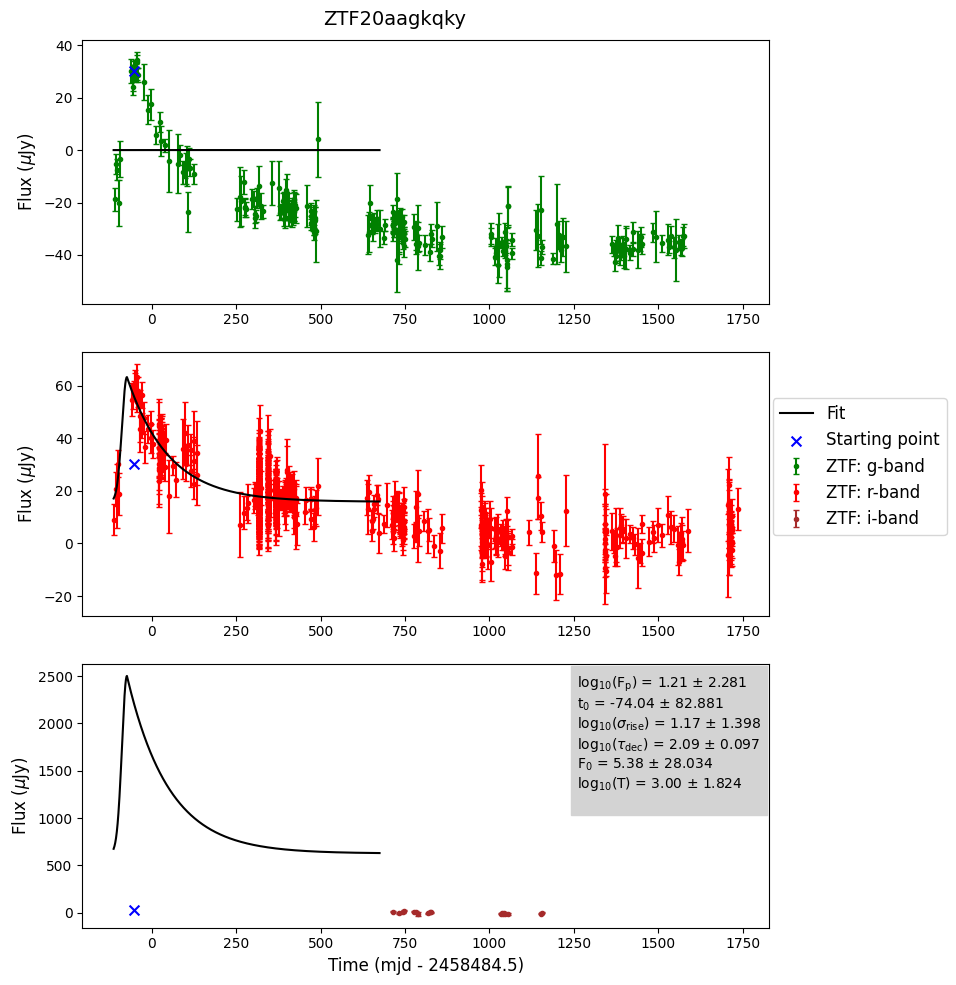

In [75]:
err_ztf = 'ZTF18acbztng'
err_ztf_path = os.path.join(sjoertpath,err_ztf)
# print(ztf_name+"_clean_data.json")
err_data = pd.read_csv(os.path.join(err_ztf_path,err_ztf+"_clean_data.txt"),sep='\t',comment='#',names=['time','flux','flux_unc','zeropoint','filter'])
print(err_data['filter'].unique())
err_ztf_obj = ZTF_forced_phot(err_ztf)
# err_ztf_obj.plot_clean_unclean_data()
# print(err_ztf_obj.guesses,'\n',err_ztf_obj.boundings)

# err_ztf_obj.plot_clean_unclean_data()
err_ztf_obj.fit()


## special case

[2.2268529212653063, 36.50416669994593, 1, 2.5, 75.52396435845233, 4]


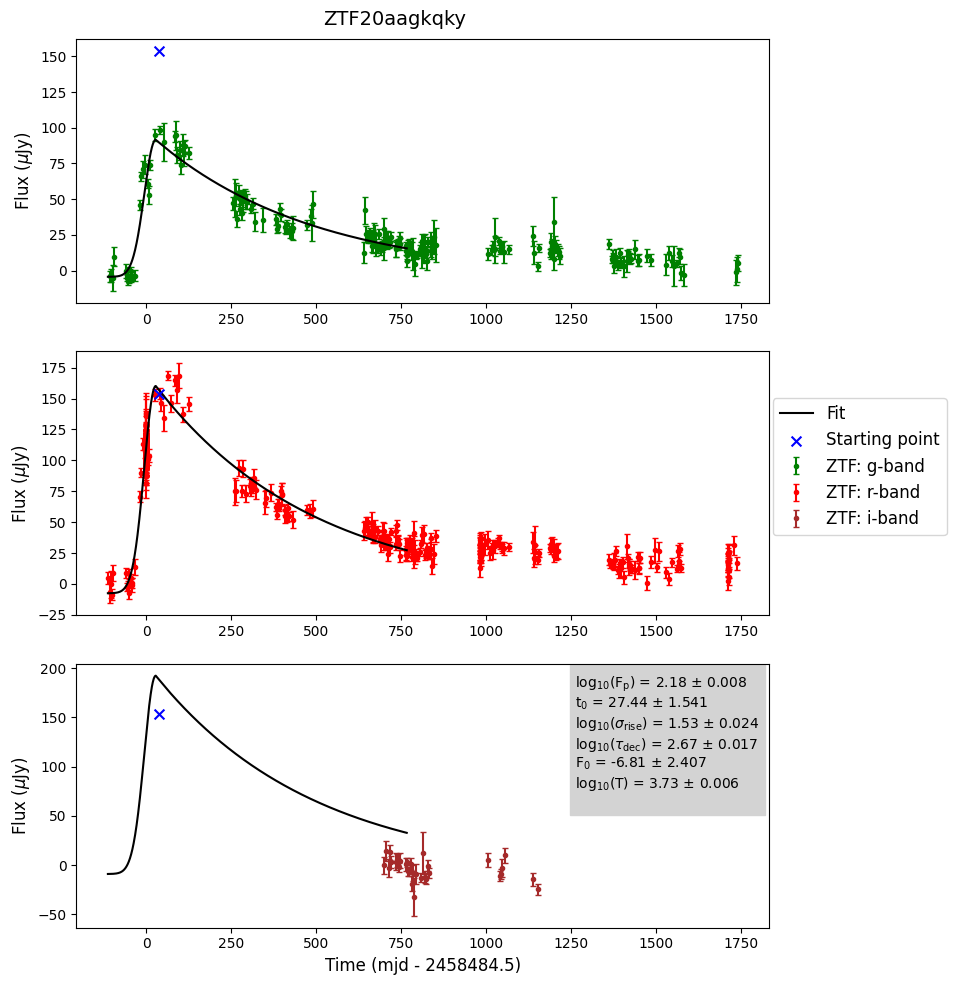

In [77]:
test_ztf = 'ZTF18acvvudh'
test_ztf_path = os.path.join(sjoertpath,test_ztf)
test_ztf_data = pd.read_csv(os.path.join(test_ztf_path,test_ztf+"_clean_data.txt"),sep='\t',comment='#',names=['time','flux','flux_unc','zeropoint','filter'])
ztf = ZTF_forced_phot(test_ztf)
# ztf.plot_clean_unclean_data()
# ztf.guesses = [2.2268529212653063, 36.50416669994593, 1, 2.5, 100.6986191446031, 4]
print(ztf.guesses)

ztf.fit()

In [78]:
boundings = list(zip(*ztf.boundings))
for i in range(5):
    print(f"Boundings: {boundings[i]}, guess: {ztf.guesses[i]}")
print(ztf.boundings,ztf.guesses)

Boundings: (1, 2.5278829169292876), guess: 2.2268529212653063
Boundings: (-63.49583330005407, 136.50416669994593), guess: 36.50416669994593
Boundings: (0, 4), guess: 1
Boundings: (0, 4), guess: 2.5
Boundings: (-32.319085433204876, 84.29909759254896), guess: 75.52396435845233
([1, -63.49583330005407, 0, 0, -32.319085433204876, 3], [2.5278829169292876, 136.50416669994593, 4, 4, 84.29909759254896, 5]) [2.2268529212653063, 36.50416669994593, 1, 2.5, 75.52396435845233, 4]
